In [7]:
import DataAnalysis as da
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.optimize as opt
%matplotlib inline

In [11]:
with open(f"pickled_fit", 'rb') as file:
    var = pickle.load(file=file)
    x_calibration = var["x"]
    y_calibration = var["y"]
    
def fit_func(x, x_lst, y_lst):
    def helperClosest(x, lst):
        assert x >= min(lst) and x <= max(lst), f"x={x} is not in [{min(lst)},{max(lst)}]"
        range_lst = max(lst) - min(lst)
        x = x - min(lst)
        low_index = int(x//1e-9)
        high_index = low_index + 1
        print(lst[low_index], lst[high_index])
        return low_index, high_index
    def helperFarthest(x):
        a, b = helperClosest(x, x_lst)
        b_weight = (x-x_lst[a])/(x_lst[b]-x_lst[a])
        a_weight = 1 - b_weight
        print(a_weight, b_weight)
        return a_weight*y_lst[a] + b_weight*y_lst[b]
    if (type(x)==type([])):
        return [helperFarthest(val) for val in x]
    return helperFarthest(x)
calibration_model = lambda val: fit_func(val, x_calibration, y_calibration)

### Load in Data for Peak Wavelength vs Photocurrent, Convert units, Propagate Error in Wavelength

In [12]:
wavelength = np.array([510, 480, 450, 520, 530, 550, 575, 565, 540, 585, 600]) #nanometers
w_err = 7e-9 #meters
wavelength_m = np.array([(1e-9)*i for i in wavelength]) #wavelength in meters

wavelength_with_error = da.get_uncertain_array(wavelength_m, w_err) #propagate error

photocurrent_nA = np.array([43, 29, 14, 40, 32, 18, 3, 7, 32, 3, 0]) #nanoamps
photocurrent = np.array([(1e-9)*i for i in photocurrent_nA]) #Amps
p_err = 4e-9 #Amps, #Error in photocurrent as observed in lab

def frequency(w):
    "Function for converting wavelengths to frequencies"
    return (3*(1e8))/w

freq_with_error = np.array([frequency(i) for i in wavelength_with_error]) #frequency data with error as single object

#Divide frequency array into separate frequency and error objects
freq = da.seperate_uncertainty_array(freq_with_error) #Hertz

### Plot of frequency vs. photocurrent

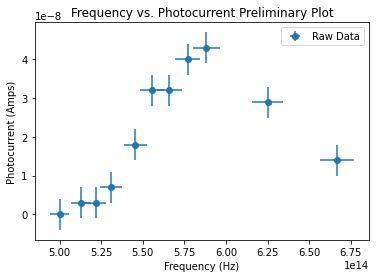

In [13]:
plt.figure()
plt.title("Frequency vs. Photocurrent Preliminary Plot")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Photocurrent (Amps)")
plt.errorbar(x=freq[0], y=photocurrent, xerr=freq[1], yerr=p_err, fmt="o", label="Raw Data")
plt.legend()

### Weighted Fit for data

5.09e-07 5.100000000000001e-07
1.0591527654923993e-13 0.9999999999998941
4.800000000000001e-07 4.81e-07
1.0 0.0
4.5e-07 4.51e-07
0.999999999999947 5.29395592033926e-14
5.2e-07 5.21e-07
1.0 0.0
5.3e-07 5.31e-07
1.0 0.0
5.5e-07 5.51e-07
1.0 0.0
5.75e-07 5.760000000000001e-07
1.0 0.0
5.64e-07 5.65e-07
0.0 1.0
5.4e-07 5.410000000000001e-07
1.0 0.0
5.85e-07 5.860000000000001e-07
1.0 0.0
6e-07 6.009999999999999e-07
0.9999999999998941 1.058791184067908e-13


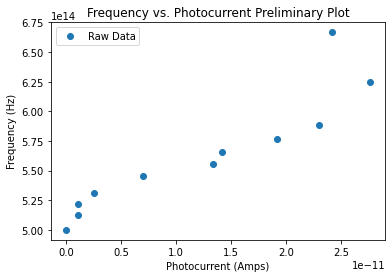

In [27]:
##use linear fit, then analyze fit after normalizing with garima's model.
wave = [3e8/f for f in freq[0]]
weighted_photocurrent = np.divide(photocurrent, calibration_model(wave))
plt.figure()
plt.title("Frequency vs. Photocurrent Preliminary Plot")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Photocurrent (Amps)")
plt.errorbar(x=weighted_photocurrent, y=freq[0], fmt="o", label="Raw Data")
plt.legend()

In [34]:
da.weighted_least_squares_linear(weighted_photocurrent[2:-2], freq[0][2:-2],np.ones(len(freq[0][2:-2])))

m = 5.1e+24±4.8e+10, c = 5.1e+14±0.67, Χ² = 2.9e+27
Equation: y = (5.1e+24±4.8e+10)*x + (5.1e+14±0.67)


([5.051764083647548e+24, 507420395696818.44],
 [47943448580.31653, 0.6737743198815253],
 [array([6.29216733e+14, 6.04158105e+14, 5.78794418e+14, 5.42918703e+14,
         5.12994162e+14, 5.20524454e+14, 5.74743589e+14]),
  array([-3.74499336e+13,  2.72350277e+13,  1.27566822e+13, -2.53584266e+12,
         -8.74496890e+12, -1.04489977e+13,  1.91880330e+13])],
 [2.867244346703723e+27])

In [36]:
1/(5.1e+24/4.475e6)


8.77450980392157e-19